```{index} single: application; cryptocurrency arbitrage
```
```{index} single: solver; cbc
```
```{index} web scraping
```
```{index} pandas dataframe
```
```{index} networkx
```
```{index} network optimization
```

# Cryptocurrency arbitrage search

Crpytocurrency exchanges are web services for the purchase, sale, and exchange of cryptocurrencies. These exchanges provide liquidity for owners and establish the relative value of these currencies. As of this writing (early 2023), [it is estimated](https://www.statista.com/statistics/730876/cryptocurrency-maket-value/) cryptocurrencies have a collective market capitalization over one trillion USD. Cryptocurrency markets are constantly changing with the introduction of new currencies, new exchanges, the occasional collapse currencies, and highly volatile prices.

This notebook explores the efficiency of cryptocurrency exchanges by testing for arbitrage opportunities. Arbitrage happens when a trader realizes a risk-free profit through a sequence of trades. The efficient market hypothesis suggests arbitrage opportunities are quickly identified and exploited by traders. As a result of their activity, prices reach a new equilibrium where the arbitrage opportunities quickly disappear. The question explored here is whether real-time and fast execution make it is feasible for a trader to profit from these fleeting arbitrage opportunities.

## Installations and Imports


### Pyomo and Solvers

First we import Pyomo and necessary solvers.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

### CCXT

In addition to Pyomo and other standard Python libraries, this notebook uses the [open-source library `ccxt`](https://github.com/ccxt/ccxt). `ccxt` supports the real-time APIs of the largest and most common exchanges on which cryptocurrencies are traded. The library can be installed with

    !pip install ccxt

Here we import all needed libraries and `ccxt`.

In [2]:
import os
import sys
from time import time
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyomo.environ as pyo

### Networkx

This notebook uses the [networkx](https://networkx.org/) library to display exchange and market data. Networkx has been updated recently to version 3.0, but that update has not yet propogated through common Python distributions. If the code that follows in this notebook may generate errors on displaying networkx diagrams, it may be necessary to update the networkx library. This can be done with the following command executed in a new cell.

    !pip install networkx --upgrade

## Cryptocurrency exchanges

Cryptocurrency exchanges are digital marketplaces for buying and trading cryptocurrencies. Joining an exchange enables a member to maintain multiple currencies in a digital wallet, to buy and sell currencies, and to use cryptocurrencies for financial transactions.  Here we import the library and list current exchanges supported by `ccxt`.

In [3]:
import ccxt

print("Available exchanges:\n")
for i, exchange in enumerate(ccxt.exchanges):
    print(f"{i+1:3d}) {exchange.ljust(20)}", end="" if (i+1) % 4 else "\n")

Available exchanges:

  1) ace                   2) alpaca                3) ascendex              4) bequant             
  5) bigone                6) binance               7) binancecoinm          8) binanceus           
  9) binanceusdm          10) bit2c                11) bitbank              12) bitbay              
 13) bitbns               14) bitcoincom           15) bitfinex             16) bitfinex2           
 17) bitflyer             18) bitforex             19) bitget               20) bithumb             
 21) bitmart              22) bitmex               23) bitopro              24) bitpanda            
 25) bitrue               26) bitso                27) bitstamp             28) bitstamp1           
 29) bittrex              30) bitvavo              31) bkex                 32) bl3p                
 33) blockchaincom        34) btcalpha             35) btcbox               36) btcex               
 37) btcmarkets           38) btctradeua           39) btcturk       

## Representing an exchange as a directed graph

Cryptocurrency exchanges facilitate trading between different cryptocurrencies through markets, which are labeled with symbols common across all exchanges. These symbols consist of an upper case string with abbreviations for the traded currency pair, separated by a slash (/). The first abbreviation is the base currency and the second is the quote currency. Prices for the base currency are denominated in units of the quote currency. Each market symbol can refer to a *bid* (an offer to buy a specified quantity of the base currency for no more than than a specified price) or to an *ask* (an offer to sell a specified quantity of the base currency for no less than a specified price).

Market symbols can be used to construct a directed graph representing an exchange, where nodes correspond to currencies and edges correspond to market symbols. The source node of an edge represents the quote currency, and the destination node represents the base currency.

The in-degree of a node indicates the number of incoming edges, while the out-degree represents the number of outgoing edges. Nodes with out-degrees greater than zero are currencies used to quote the price of other currencies and are highlighted. Nodes with in-degree below a specified threshold, called the `minimum_in_degree`, have fewer markets and are not displayed or analyzed further.


Number of nodes =  15
Number of edges =  60


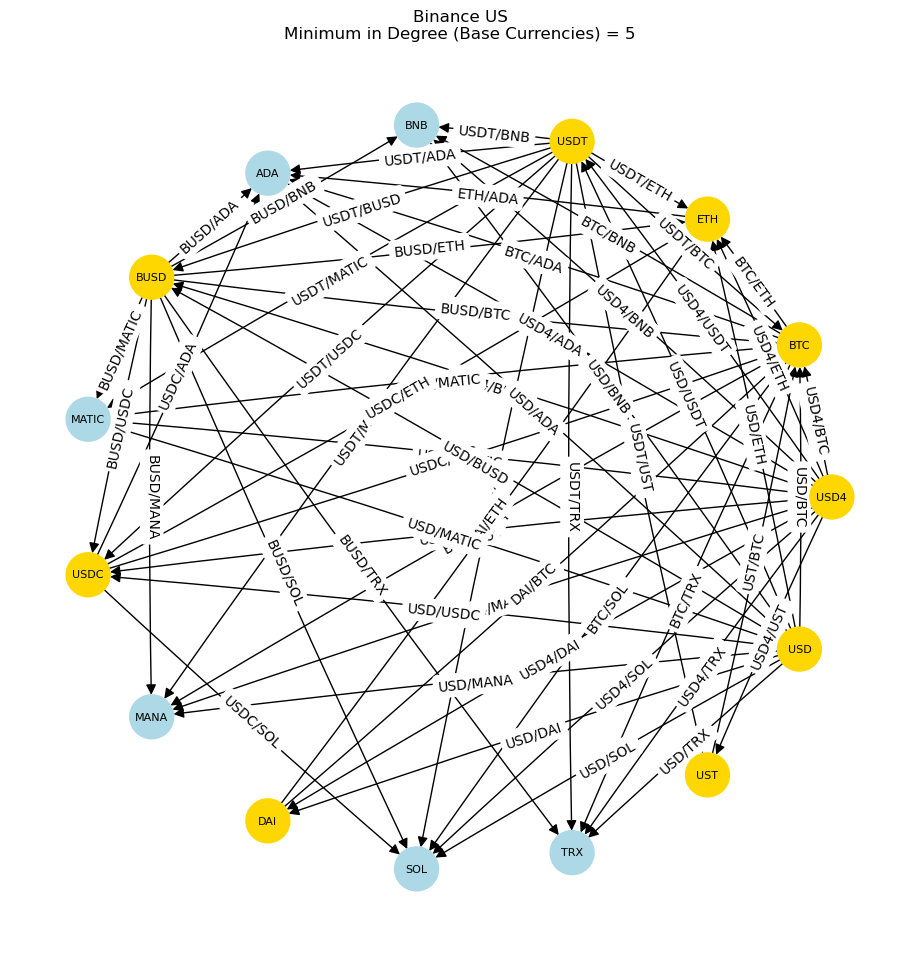

In [4]:
# global variables used in subsequent cells

# create an exchange object
exchange = ccxt.binanceus()

def get_dg(exchange, minimum_in_degree=1):
    """
    Return a directed graph constructed from the market symbols on a specified exchange.
    """
    markets = exchange.load_markets()
    symbols = markets.keys()

    # create an edge for all market symbols
    dg = nx.DiGraph()
    for base, quote in [symbol.split("/") for symbol in symbols]:
        dg.add_edge(quote, base, color="k", width=1)
    
    # remove base currencies with in_degree less than minimum_in_degree
    remove_nodes = [node for node in dg.nodes if dg.out_degree(node) == 0 and dg.in_degree(node) < minimum_in_degree]
    dg.remove_nodes_from(remove_nodes)
    
    # color quote currencies in gold
    for node in dg.nodes():
        dg.nodes[node]["color"] = "gold" if dg.out_degree(node) > 0 else "lightblue"

    return dg

def draw_dg(dg, rad=0.0):
    """
    Draw directed graph of markets symbols.
    """
    n_nodes = len(dg.nodes)
    size = int(2.5 * np.sqrt(n_nodes))
    fig = plt.figure(figsize=(size, size))
    pos = nx.circular_layout(dg)
    nx.draw(
        dg, 
        pos,
        with_labels=True,
        node_color=[dg.nodes[node]["color"] for node in dg.nodes()],
        edge_color=[dg.edges[u, v]["color"] for u, v in dg.edges],
        width=[dg.edges[u, v]["width"] for u, v in dg.edges],
        node_size=1000,
        font_size=8,
        arrowsize=15,
        connectionstyle=f"arc3, rad={rad}",
    )
    nx.draw_networkx_edge_labels(dg, pos, edge_labels={(src, dst): f"{src}/{dst}" for src, dst in dg.edges()})

    return plt.gca()

minimum_in_degree = 5
dg = get_dg(exchange, minimum_in_degree)
ax = draw_dg(dg, 0.01)
ax.set_title(exchange.name + "\n" + f"Minimum in Degree (Base Currencies) = {minimum_in_degree}")

print(f"Number of nodes = {len(dg.nodes()):3d}")
print(f"Number of edges = {len(dg.edges()):3d}")

## Exchange order book

The **order book** is the real-time inventory of trading orders on an given exchange. 

A **bid** is an order to buy up to a specified amount of the base currency. The price is not to exceed the 'bid price' specified in the quote currency. The exchange attempts to match the bid to a sell order at a price less than or equal to the bid price. If a transaction occurs the  buyer receives an amount of base currency less than or equal to the bid volume at a price less than or equal to the bid price.

An **ask** is an offer to sell up to a specified amount of the base currency for a price no less than a specified value  given in the quote currency. If a transaction occurs, then seller will sell no more than a specified about of the base currency at a price no less than the specified value. 

The exchange order book maintains a list of all active orders for symbols traded on the exchange. Incoming bids above the lowest ask or incoming asks below the highest bid will be immediately matched and transactions executed following rules of the exchange. 

The follow cell reads a previously saved order book.  Cells at the end of this notebook demonstrate how to retrieve an order book from an exchange and save it as a Pandas DataFrame.

In [5]:
import glob

# find all previously saved order books
fnames = sorted(glob.glob(f"*orderbook*".replace(" ","_")))
print("Previously saved order books:")
for fname in fnames:
    print(f"\t{fname}")
    
# read the oldest
order_book = pd.read_csv(fnames[0])
display(order_book)


Previously saved order books:
	Binance_US_orderbook_20230302_15_36_09.csv
	Binance_US_orderbook_20230303_01_47_15.csv


Unnamed: 0      symbol                timestamp   base quote  \
0            0     ETH/BTC  2023-03-02 15:36:06.529    ETH   BTC   
1            1     BNB/BTC  2023-03-02 15:36:06.583    BNB   BTC   
2            2     ADA/BTC  2023-03-02 15:36:06.637    ADA   BTC   
3            3     SOL/BTC  2023-03-02 15:36:06.690    SOL   BTC   
4            4   MATIC/BTC  2023-03-02 15:36:06.750  MATIC   BTC   
5            5    MANA/BTC  2023-03-02 15:36:06.848   MANA   BTC   
6            6     TRX/BTC  2023-03-02 15:36:06.905    TRX   BTC   
7            7     ADA/ETH  2023-03-02 15:36:06.960    ADA   ETH   
8            8    BTC/USDT  2023-03-02 15:36:07.012    BTC  USDT   
9            9    ETH/USDT  2023-03-02 15:36:07.065    ETH  USDT   
10          10    BNB/USDT  2023-03-02 15:36:07.118    BNB  USDT   
11          11    ADA/USDT  2023-03-02 15:36:07.172    ADA  USDT   
12          12   BUSD/USDT  2023-03-02 15:36:07.226   BUSD  USDT   
13          13    SOL/USDT  2023-03-02 15:36:07.288    SOL  USDT   
14          14   USDC/USDT  2023-03-02 15:36:07.342   USDC  USDT   
15          15  MATIC/USDT  2023-03-02 15:36:07.394  MATIC  USDT   
16          16   MANA/USDT  2023-03-02 15:36:07.447   MANA  USDT   
17          17    TRX/USDT  2023-03-02 15:36:07.501    TRX  USDT   
18          18    BTC/BUSD  2023-03-02 15:36:07.612    BTC  BUSD   
19          19    BNB/BUSD  2023-03-02 15:36:07.665    BNB  BUSD   
20          20    ETH/BUSD  2023-03-02 15:36:07.719    ETH  BUSD   
21          21  MATIC/BUSD  2023-03-02 15:36:07.772  MATIC  BUSD   
22          22   USDC/BUSD  2023-03-02 15:36:07.893   USDC  BUSD   
23          23   MANA/BUSD  2023-03-02 15:36:07.950   MANA  BUSD   
24          24    ADA/BUSD  2023-03-02 15:36:08.003    ADA  BUSD   
25          25    SOL/BUSD  2023-03-02 15:36:08.056    SOL  BUSD   
26          26    TRX/BUSD  2023-03-02 15:36:08.114    TRX  BUSD   
27          27    BTC/USDC  2023-03-02 15:36:08.170    BTC  USDC   
28          28    ETH/USDC  2023-03-02 15:36:08.228    ETH  USDC   
29          29    SOL/USDC  2023-03-02 15:36:08.298    SOL  USDC   
30          30    ADA/USDC  2023-03-02 15:36:08.368    ADA  USDC   
31          31     BTC/DAI  2023-03-02 15:36:08.433    BTC   DAI   
32          32     ETH/DAI  2023-03-02 15:36:08.485    ETH   DAI   
33          33     BTC/USD  2023-03-02 15:36:08.623    BTC   USD   
34          34     ETH/USD  2023-03-02 15:36:08.675    ETH   USD   
35          35    USDT/USD  2023-03-02 15:36:08.730   USDT   USD   
36          36     BNB/USD  2023-03-02 15:36:08.782    BNB   USD   
37          37     ADA/USD  2023-03-02 15:36:08.835    ADA   USD   
38          38    BUSD/USD  2023-03-02 15:36:08.942   BUSD   USD   
39          39   MATIC/USD  2023-03-02 15:36:08.998  MATIC   USD   
40          40    USDC/USD  2023-03-02 15:36:09.051   USDC   USD   
41          41    MANA/USD  2023-03-02 15:36:09.102   MANA   USD   
42          42     DAI/USD  2023-03-02 15:36:09.155    DAI   USD   
43          43     SOL/USD  2023-03-02 15:36:09.217    SOL   USD   
44          44     TRX/USD  2023-03-02 15:36:09.270    TRX   USD   

       bid_price     bid_volume     ask_price     ask_volume  
0       0.069735       0.012000      0.069759       0.050000  
1       0.012743       0.050000      0.012755       3.000000  
2       0.000015       2.000000      0.000015    2168.000000  
3       0.000935       1.420000      0.000936      15.120000  
4       0.000052      26.200000      0.000052     150.200000  
5       0.000027     831.000000      0.000027    1409.000000  
6       0.000003       4.000000      0.000003   25352.000000  
7       0.000214     994.900000      0.000214     891.600000  
8   23373.920000       0.118619  23376.000000       0.045275  
9    1630.200000       0.950000   1630.770000       0.500000  
10    297.857700       0.800000    297.891900       0.800000  
11      0.348630    1100.000000      0.348750     511.200000  
12      0.999500  293433.930000      0.999600  317175.73

## Representing the order book as a directed graph

Here we represent the order book as a directed graph where nodes correspond to individual currencies. 

A directed edge $i\rightarrow j$ from node $i$ to node $j$ describes an opportunity for a currency trader to convert currency $i$ into currency $j$. A buy order in the order book for market symbol $b/q$ is an order from someone else to purchase base currency $b$ at bid price given in the quote currency. The bid volume specifies the maximum amount base currency available. A currency trader is a potential counterparty to that transaction. For the trader, the buy order is an opportunity to convert the base currency $b$ into the quote currency $q$. 

Let $w_b$ and $w_q$ denote the amounts of each currency held by the currency trader, and let $x_{b\rightarrow q}(k)$ denote transaction number $t$ where an amount of currency $b$ exchanged for currency $q$. Following the transaction

$$\begin{align*}
w_b(t) & = w_b(t-1) - x_{b\rightarrow q}(t) \\
w_q(t) & = w_q(t-1) + a_{b\rightarrow q} x_{b\rightarrow q}(t)
\end{align*}
$$

where $a_{b\rightarrow q}$ is a 'conversion' coefficient equal to the bid price for $b$ expressed in terms of currency $q$. The corresponding capacity $c_{b\rightarrow q}$ of an edge $b\rightarrow q$ is specified by a relationship

$$x_{b\rightarrow q} \leq c_{b\rightarrow q}$$

Each bid on the order book for symbol $b/q$ results in edge labeled by

$$
\begin{align*}
a_{b\rightarrow q} & = \text{bid price} \\
c_{b\rightarrow q} & = \text{bid volume}
\end{align*}
$$

A sell order for symbol $b/q$ is an order to sell the base currency at price not less than the 'ask' price given in terms of the quote currency. The ask volume is the amount of base currency to be sold. For a currency trader, a sell order is an opportunity to convert the quote current into the base currency such that

$$
\begin{align*}
a_{q\rightarrow b} & = \frac{1}{\text{ask price}} \\
c_{q\rightarrow b} & = \text{ask volume} \times \text{ask price}
\end{align*}
$$

The following cell creates a directed graph using data from an exchange order book.

Text(0.5, 1.0, "\nTrader's View of an Order Book\nGreen: Trader accepts a bid order\nRed: Trader accepts a sell order\n")

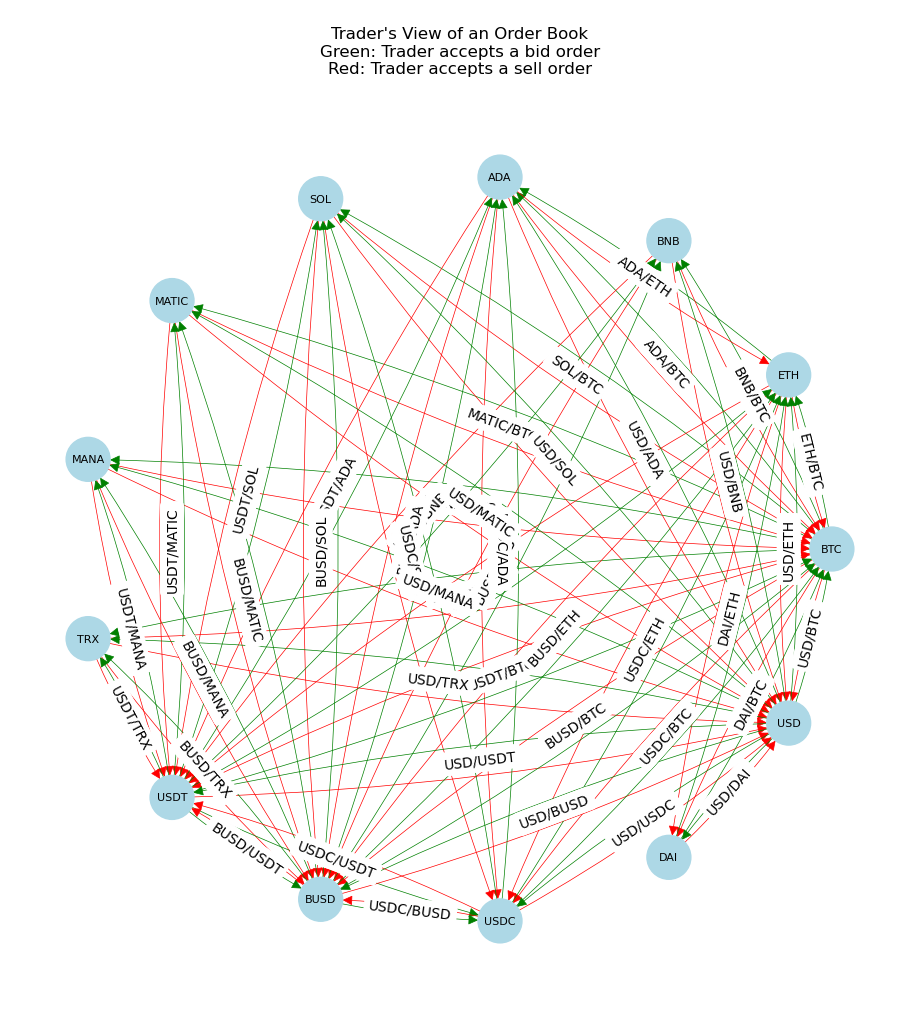

In [6]:
def order_book_to_dg(order_book):

    # create a dictionary of edges index by (src, dst)
    dg_order_book = nx.DiGraph()
    
    for symbol in order_book.index:
        # buy ('bid'): offer to purchase base. Converts quote currency to base currency
        if not np.isnan(order_book.at[symbol, "bid_volume"]):
            src = order_book.at[symbol, "quote"]
            dst = order_book.at[symbol, "base"]
            dg_order_book.add_edge(src, dst,
                kind = "bid",
                a = order_book.at[symbol, "bid_price"],
                capacity = order_book.at[symbol, "bid_volume"],
                weight = - np.log(order_book.at[symbol, "bid_price"]),
                color = "g",
                width = 0.5,
            )

        # sell ('ask') orders
        if not np.isnan(order_book.at[symbol, "ask_volume"]):
            src = order_book.at[symbol, "base"]
            dst = order_book.at[symbol, "quote"]
            dg_order_book.add_edge(src, dst,
                kind = "ask",
                a = 1.0 / order_book.at[symbol, "ask_price"],
                capacity = order_book.at[symbol, "ask_volume"] * order_book.at[symbol, "ask_price"],
                weight = - np.log(1.0 / order_book.at[symbol, "ask_price"]),
                color = "r",
                width = 0.5,
            )

    for node in dg_order_book.nodes():
        dg_order_book.nodes[node]["color"] = "lightblue"

    return dg_order_book


dg_order_book = order_book_to_dg(order_book)
ax = draw_dg(dg_order_book, 0.05)
ax.set_title("""
Trader's View of an Order Book
Green: Trader accepts a bid order
Red: Trader accepts a sell order
""")


## Arbitrage

An arbitrage exists if it is possible to find a closed path and a sequence of transactions in the directed graph that results in a net increase in currency holdings. Consider a path

$$i_0 \rightarrow i_1 \rightarrow i_2 \rightarrow \cdots \rightarrow i_{n-1} \rightarrow i_n$$

The path is closed if $i_n = i_0$. The path has non-zero capacity if each edge in the path has a non-zero capacity. For a sufficiently small holding $w_{i_0}$ of currency $i_0$, the closed path with $i_0 = i_n$ represents an arbitrage opportunity if 

$$\prod_{k=0}^{n-1} a_{i_k\rightarrow i_{k+1}} > 1$$

To apply the shortest path algorithms from the NetworkX library, we assign a each edge a weight equal to the negative logarithm of the conversion coefficients. Then if the shortest path algorithm returns a path with negative length that path will yield a positive financial return.

$$w_{i\rightarrow j} = - \log a_{i\rightarrow j}$$

Designating the source and destination as nodes $i_{0}$ and $i_{n}$, the largest return is given by a path minimizing the sum of weights computed as

$$
\begin{align*}
& \min\; W \\
& \text{s.t.}\; W = \sum_{k=0}^{n-1} w_{i_k \rightarrow i_{k+1}}\\
\end{align*}
$$

An arbitrage exists if path length $W < 0$ for any path where $i_0 = i_n$.

## Negative edge cycles imply arbitrage

A brute force search over all simple cycles has complexity $(n + e)(c + 1)$ which is impractical for larger scale applications. A more efficient search based on the Bellman-Ford algorithm is embedded in the NetworkX function [`negative_edge_cycle`](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.negative_edge_cycle.html) that returns a logical True if a negative cycle exists in a directed graph. 

Note that the Bellman-Ford test only the proves the existence of at least one closed-cycle demonstrating arbitrage. If there is one, there may be other cycles  have higher or lower return, and that allow for higher or lower trading volumes.

In [7]:
dg_order_book = order_book_to_dg(order_book)
nx.negative_edge_cycle(dg_order_book, weight="weight", heuristic=True)

True

The NetworkX library includes a function [`find_negative_cycle`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.find_negative_cycle.html) that locates a single negative edge cycle, if one exists. We can use this to demonstrate the existence of an arbitrage opportunity, and to highlight that opportunity on the directed graph of all possible trades. The following cell reports the cycle found and the trading return measured in basis points (1 bp = 0.01%) 

Note this may or may not the trading cycle with maximum return. There may be other cycles with higher or lower returns, and that allow higher or lower trading volumes.

Trading cycle: ['BUSD', 'USDT', 'USDC']
5.002 basis points


Text(0.5, 1.0, 'Candidate Trading Cycle 5.002 basis points return')

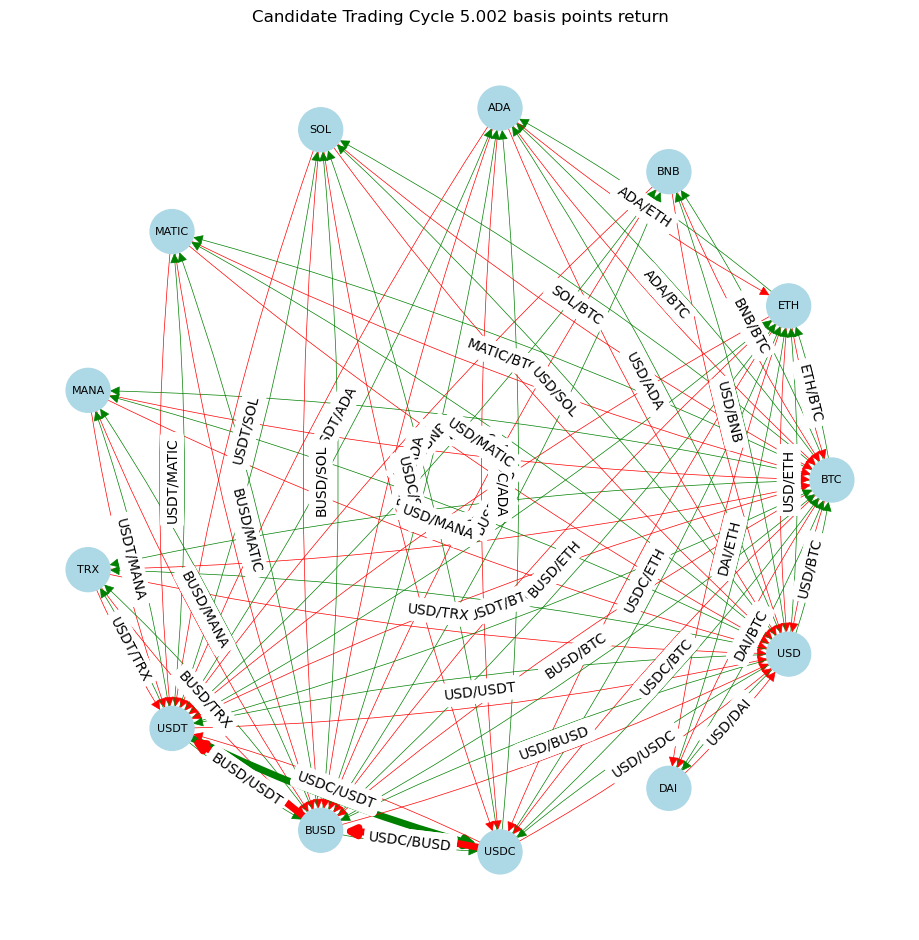

In [8]:
# compute the sum of weights given a list of nodes
def sum_weights(cycle):
    return sum([dg_order_book.edges[edge]["weight"] for edge in zip(cycle, cycle[1:] + cycle[:1])])


dg_order_book = order_book_to_dg(order_book)
arb = nx.find_negative_cycle(dg_order_book, weight="weight", source="USD")[:-1]
print(f"Trading cycle: {arb}")
bp = 10000 * (np.exp(-sum_weights(arb)) - 1)
print(f"{bp:0.3f} basis points")
    
for src, dst in zip(arb, arb[1:] + arb[:1]):
    dg_order_book[src][dst]["width"] = 5
    
ax = draw_dg(dg_order_book, 0.05)
ax.set_title(f"Candidate Trading Cycle {bp:0.3f} basis points return")

## Brute force search arbitrage with simple cycles

As a further "brute force" demonstration of arbitrage in an order book, we compute the financial return for all simple cycles that can be constructed within a directed graph.

A simple cycle is a closed path where no node appears twice. Simple cycles are distinct if they are not cyclic permutations of each other. The following cell uses [`simple_cycles`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html) from the NetworkX library to construct a dictionary of all distinct simple cycles in the order book. Cycles are represented by an ordered list of nodes comprising the cycle. The existence of a simple cycle with positive financial return (i.e, negative log loss in terms of the edge weights) indicates an arbitrage opportunity.

There are 203147 distinct simple cycles in the order book.
   974 of the cycles have positive return.


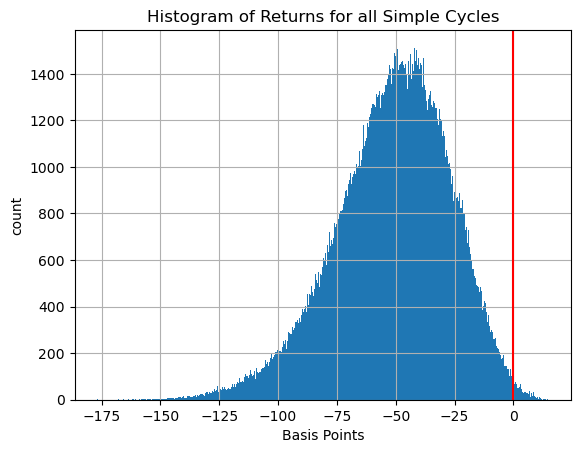

In [9]:
# This cell iterates over all simple cycles in a directed graph. This
# can a long time for a large, well connected graph. 

# convert order book to a directed graph
dg_order_book = order_book_to_dg(order_book)

# compute the sum of weights given a list of nodes
def sum_weights(cycle):
    return sum([dg_order_book.edges[edge]["weight"] for edge in zip(cycle, cycle[1:] + cycle[:1])])

# create a dictionary of all simple cycles and sum of weights
cycles = {tuple(cycle): 10000 * (np.exp(-sum_weights(cycle)) - 1) for cycle in nx.simple_cycles(dg_order_book)}

print(f"There are {len(cycles)} distinct simple cycles in the order book.")
print(f"   {len([cycle for cycle in cycles if cycles[cycle] > 0])} of the cycles have positive return.")

# create histogram
plt.hist(cycles.values(), bins=int(np.sqrt(len(cycles))))
ax = plt.gca()
ax.set_ylabel("count")
ax.set_xlabel("Basis Points")
ax.set_title("Histogram of Returns for all Simple Cycles")
ax.grid(True)
ax.axvline(0, color='r')

In [10]:
arbitrage = [cycle for cycle in sorted(cycles, key=cycles.get, reverse=True) if cycles[cycle] > 0]

print("Top 4\n")
print(f"Basis Points             Arbitrage Cycle")
for cycle in arbitrage[0: min(4, len(arbitrage))]:
    t = list(cycle)
    t.append(cycle[0])
    print(f"{cycles[cycle]:6.3f}         {len(t)} trades: {' -> '.join(t)}")

Top 4

Basis Points             Arbitrage Cycle
14.774         8 trades: ETH -> BTC -> ADA -> USDT -> USDC -> BUSD -> USD -> ETH
14.747         8 trades: ETH -> BTC -> TRX -> USDT -> USDC -> BUSD -> USD -> ETH
14.699         7 trades: USDT -> USDC -> BUSD -> USD -> BTC -> ADA -> USDT
14.673         7 trades: USDT -> USDC -> BUSD -> USD -> BTC -> TRX -> USDT


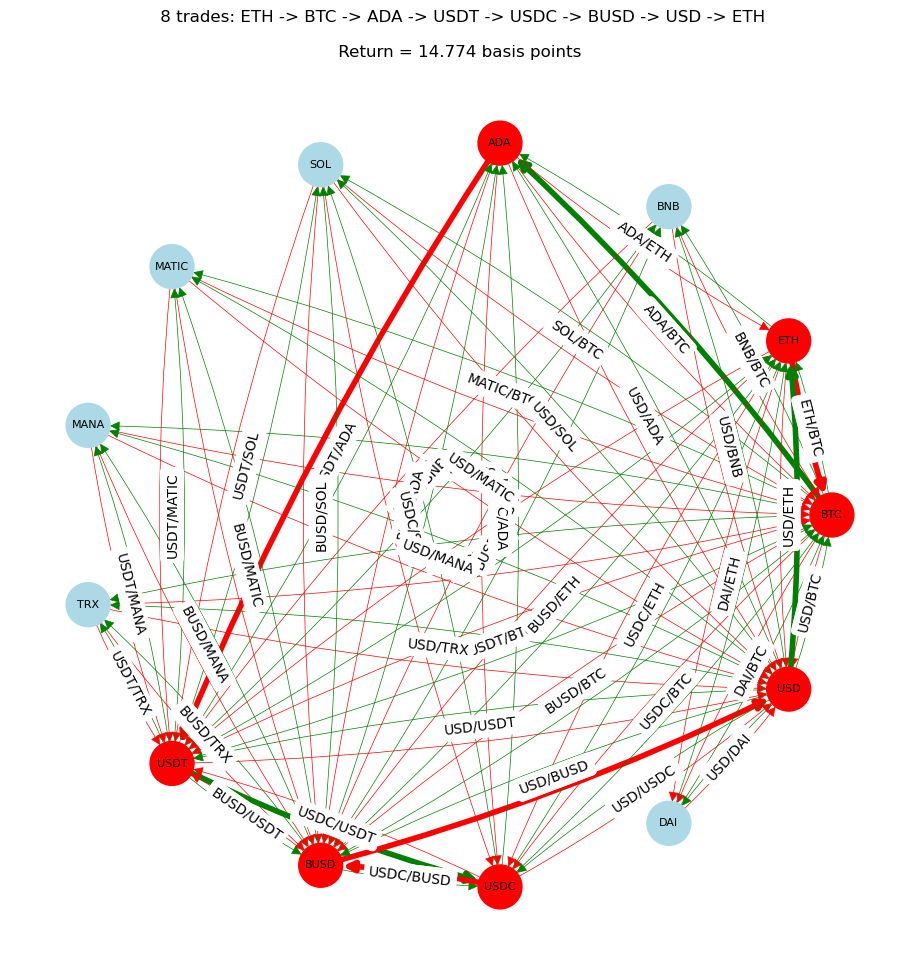

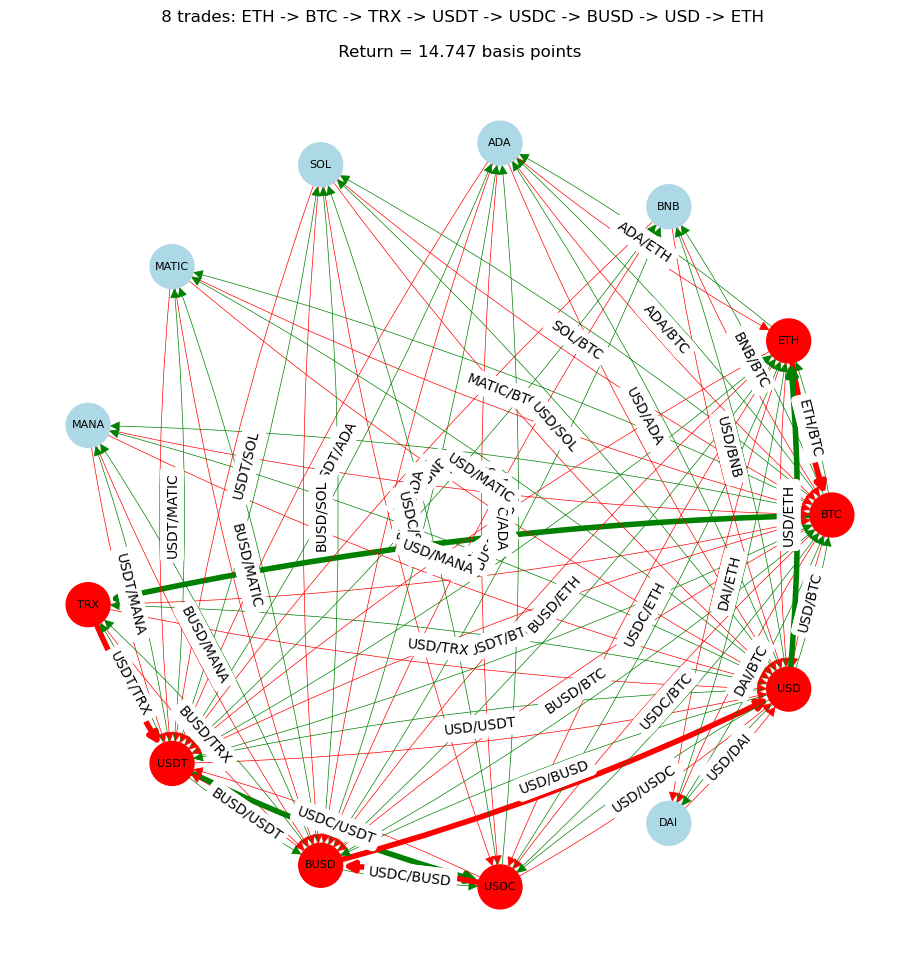

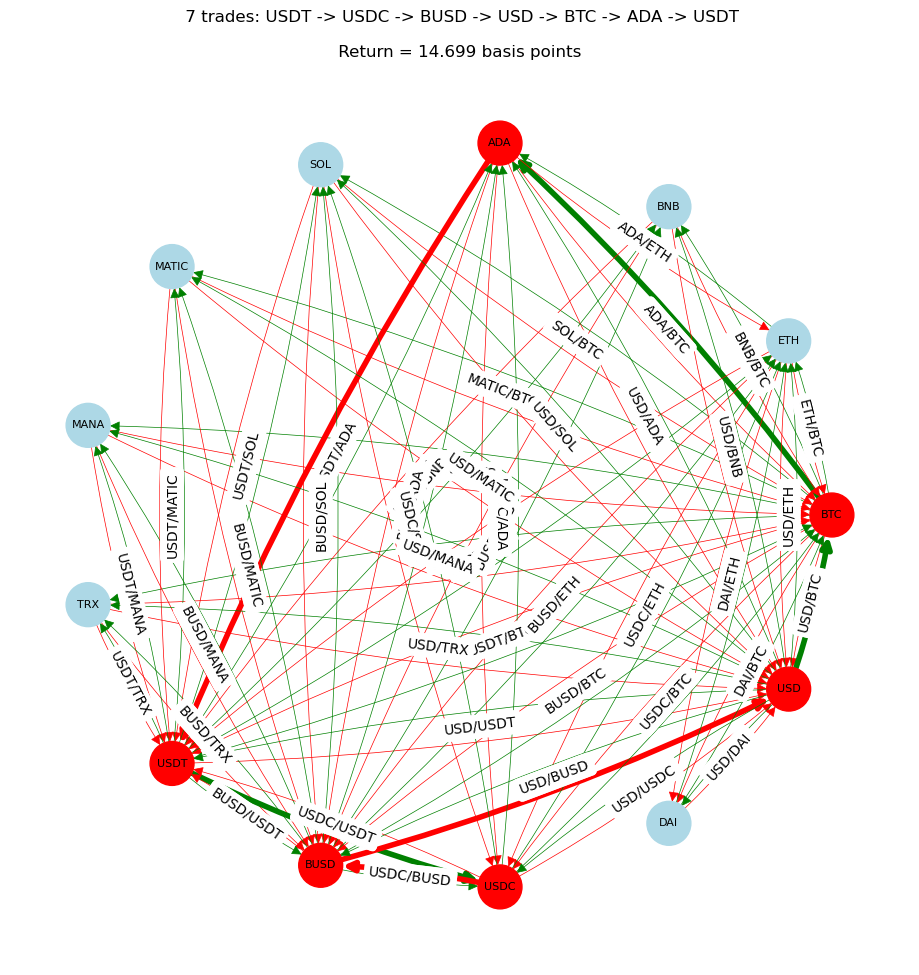

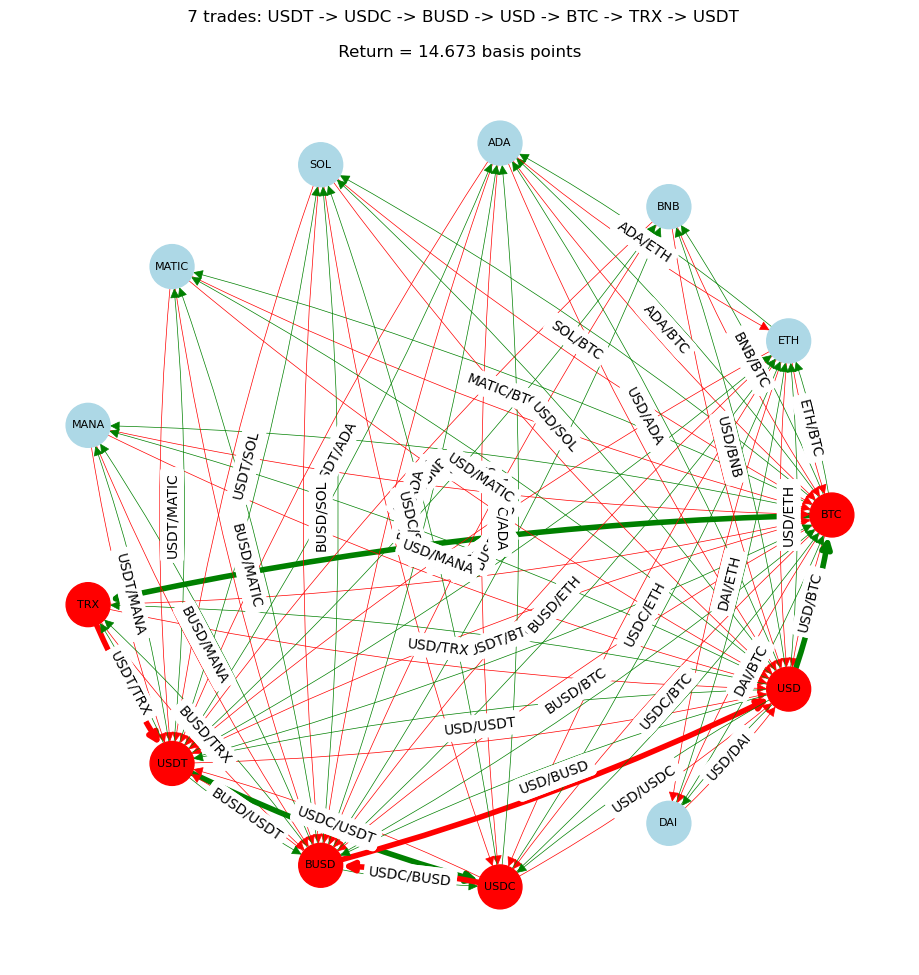

In [11]:
for cycle in arbitrage[0: min(4, len(arbitrage))]:

    # get fresh graph to color nodes
    dg_order_book = order_book_to_dg(order_book)
    
    # color nodes red
    for node in cycle:
        dg_order_book.nodes[node]['color'] = 'red'
    
    # makes lines wide
    for edge in zip(cycle, cycle[1:] + cycle[:1]):
        dg_order_book.edges[edge]['width'] = 4
        
    ax = draw_dg(dg_order_book, rad=0.05)

    t = list(cycle)
    t.append(cycle[0])
    ax.set_title(f" {len(t)} trades: {' -> '.join(t)}\n\n Return = {cycles[cycle]:6.3f} basis points ")

## Pyomo Model for Arbitrage with Capacity Constraints

The preceding analysis shows that depending on generic network algorithms to find arbitrage in an exchange order book has some practical limitations:

* Since there can be multiple negative cycles, there may be more than one opportunity for arbitrage. Which opportunity offers the greatest potential for profit?
* Shortest path algorithms do not account for capacity constraints. The network algorithms are restricted to investments small enough to satisfy all capacity constraints on every edge.

Let's consider a Pyomo optimization model to find arbitrage opportunities that maximize financial return. We assume we are given a directed graph where each edge $i\rightarrow j$ is labeled with a 'multiplier' $a_{i\rightarrow j}$ indicating how many units of currency $j$ will be received for one unit of currency $i$, and a 'capacity' $c_{i\rightarrow j}$ indicating how many units of currency $i$ can be converted to currency $j$.

The model provides up to $T$ events for a given order book. Each event may consist of zero or currency transactions on different edges. A single transaction converts $x_{i\rightarrow j}(t)$ units of currency $i$ to currency $j$. Following the all transactions at event $t$, the trader will hold $w_j(t)$ units of currency $j$ where

$$w_{j}(t) = w_{j}(t-1) + \sum_{i\in I_j} a_{i\rightarrow j}x_{i\rightarrow j}(t) - \sum_{k\in O_j} x_{j\rightarrow k}(t)$$

Set $I_j$ are the input nodes to $j$, and set $O_j$ is the set of output nodes from $j$. Each edge on the order book has a finite capacity. For every edge $i\rightarrow j$, the sum of all transactions must satisfy

$$\sum_{t=1}^T x_{j\rightarrow k}(t) \leq c_{j\rightarrow k}$$


The purpose of the optimization model is to find a sequence of currency transactions that provide a maximize holdings of a reference currency. We assume the trader cannot short sell any currency. The resulting model is given by

$$
\begin{align*}
\max \quad & w_{USD}(T) \\
\\
\text{s.t.} \quad & w_{USD}(0) = w_0 \\ 
\\
& w_{j}(t) = w_{j}(t-1) + \sum_{i\in I_j} a_{i\rightarrow j}x_{i\rightarrow j}(t) - \sum_{k\in O_k} x_{j\rightarrow k}(t) & \forall j\in NODES, t=1, 2, \ldots, T \\
& w_j(t-1) \geq \sum_{k\in O_j} x_{j\rightarrow k}(t) & \forall j\in NODES, t = 1, 2, \ldots, T  \\
& \sum_{t=1}^T x_{j\rightarrow k}(t) \leq c_{j\rightarrow k} & \forall (j, k) \in EDGES,  t = 1, 2, \ldots, T \\
\end{align*}
$$

The function `crypto_model` creates an instance of a corresponding Pyomo model.

In [12]:
import pyomo.environ as pyo

def crypto_model(dg_order_book, T = 10, w0 = 100.0):

    m = pyo.ConcreteModel(f"{exchange} arbitrage")

    # length of the trading chain
    m.T0 = pyo.RangeSet(0, T)
    m.T1 = pyo.RangeSet(1, T)

    # currency nodes and trading edges
    m.NODES = pyo.Set(initialize=list(dg_order_book.nodes))
    m.EDGES = pyo.Set(initialize=list(dg_order_book.edges))

    # currency on hand at each node
    m.w = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

    # amount traded on each edge at each trade
    m.x = pyo.Var(m.EDGES, m.T1, domain=pyo.NonNegativeReals)

    # total amount traded on each edge over all trades
    m.z = pyo.Var(m.EDGES, domain=pyo.NonNegativeReals)

    # "multiplier" on each trading edge
    @m.Param(m.EDGES)
    def a(m, src, dst):
        return dg_order_book.edges[(src, dst)]["a"]

    @m.Param(m.EDGES)
    def capacity(m, src, dst):
        return dg_order_book.edges[(src, dst)]["capacity"]

    @m.Objective(sense=pyo.maximize)
    def wealth(m):
        return m.w["USD", T]

    @m.Constraint(m.EDGES)
    def total_traded(m, src, dst):
        return m.z[src, dst] == sum([m.x[src, dst, t] for t in m.T1])

    @m.Constraint(m.EDGES)
    def edge_capacity(m, src, dst):
        return m.z[src, dst] <= m.capacity[src, dst]

    # initial assignment of 100 units on a selected currency
    @m.Constraint(m.NODES)
    def initial(m, node):
        if node == "USD":
            return m.w[node, 0] == w0
        return m.w[node, 0] == 0.0

    @m.Constraint(m.NODES, m.T1)
    def no_shorting(m, node, t):
        return m.w[node, t - 1] >= sum(m.x[node, dst, t] for src, dst in m.EDGES if src == node)

    @m.Constraint(m.NODES, m.T1)
    def balances(m, node, t):
        return m.w[node, t] == m.w[node, t - 1] \
            + sum(m.a[src, node] * m.x[src, node, t] for src, dst in m.EDGES if dst == node) \
            - sum(m.x[node, dst, t] for src, dst in m.EDGES if src == node) 

    solver = pyo.SolverFactory("cbc")
    solver.solve(m)
    
    return m

Computing the potential return from an order book.

In [13]:
dg_order_book = order_book_to_dg(order_book)

w0 = 10000.0
T = 10
m = crypto_model(dg_order_book, T=T, w0=w0)
wT = m.wealth()

print(f"Starting wealth = {w0:0.2f} USD")
print(f"Weath after {T:2d} transactions = {wT:0.2f} USD")
print(f"Return = {10000 * (wT - w0)/w0:0.3f} basis points")
print()

Starting wealth = 10000.00 USD
Weath after 10 transactions = 10012.03 USD
Return = 12.031 basis points



Trading Summary for the Order Book
  Order Book   Type    Capacity         Traded
  BTC -> BNB   bid      0.05000        0.05000  >>>  buy         0.050000 BTC/BNB     at     0.012743
  BTC -> ADA   bid      2.00000        2.00000  >>>  buy         2.000000 BTC/ADA     at     0.000015
  BTC -> MATIC bid     26.20000       26.20000  >>>  buy        26.200000 BTC/MATIC   at     0.000052
  BTC -> TRX   bid      4.00000        4.00000  >>>  buy         4.000000 BTC/TRX     at     0.000003
  BTC -> USDT  ask   1058.34840     1058.34840  >>>  sell        0.045275 USDT/BTC    at 23376.000000
  BTC -> BUSD  ask    502.60185      502.60185  >>>  sell        0.021500 BUSD/BTC    at 23376.830000
  BTC -> USD   ask   1140.90082     1140.90080  >>>  sell        0.048805 USD/BTC     at 23376.720000
  ETH -> BTC   ask      0.00349        0.00349  >>>  sell        0.050000 BTC/ETH     at     0.069759
  ETH -> BUSD  ask    415.84380      415.84380  >>>  sell        0.255000 BUSD/ETH    at  1630.760000


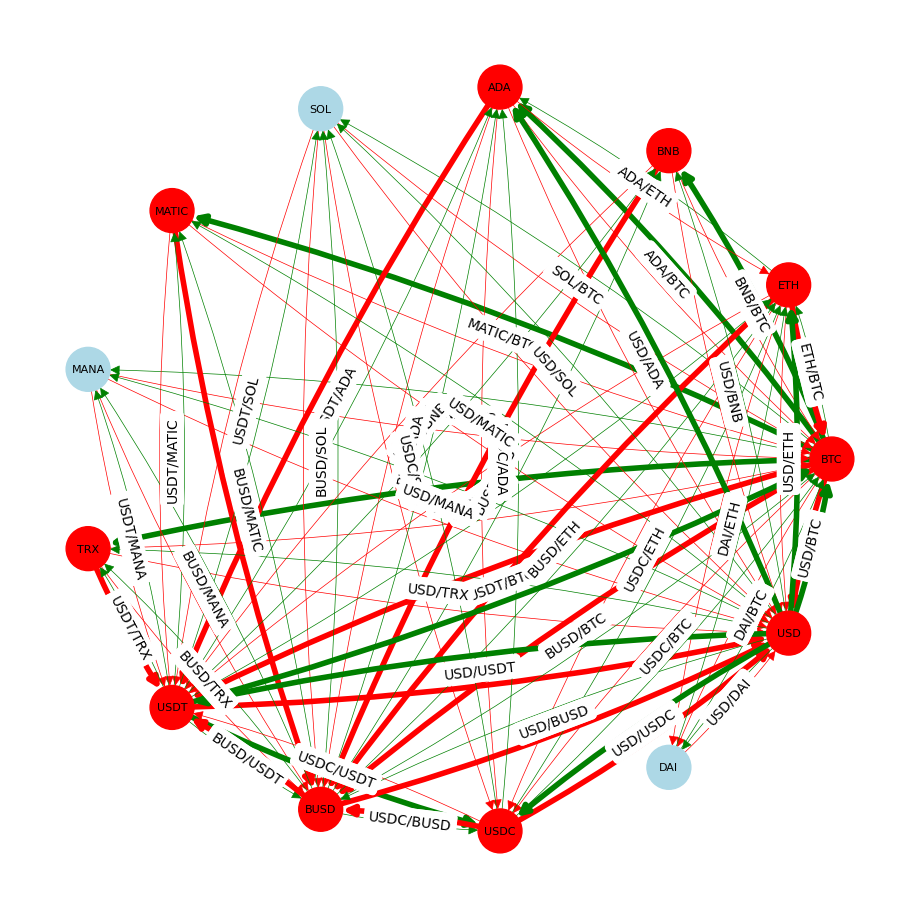

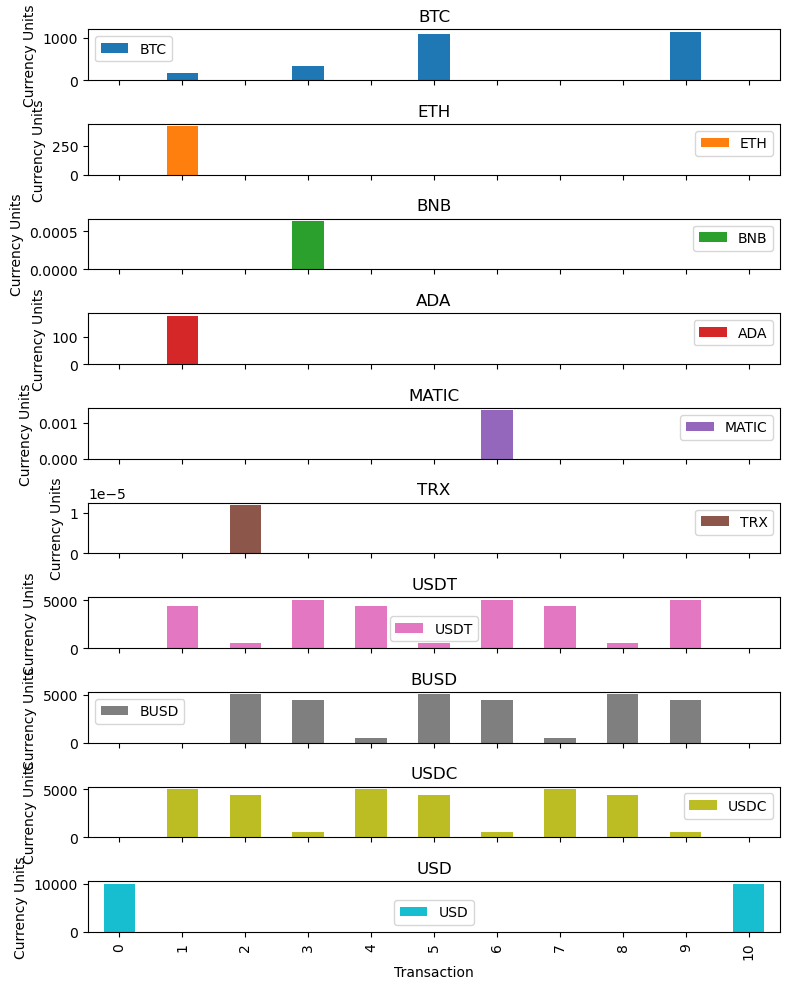

In [14]:
# report what orders to issue
for src, dst in m.EDGES:
    if m.z[src, dst]() > 0.0000002: 
        dg_order_book.nodes[src]["color"] = "red"
        dg_order_book.nodes[dst]["color"] = "red"
        dg_order_book[src][dst]["width"] = 4
                
draw_dg(dg_order_book, 0.05)

# report what orders to issue
print("Trading Summary for the Order Book")
print(f"  Order Book   Type    Capacity         Traded")
for src, dst in m.EDGES:
    if m.z[src, dst]() > 0.0000002:
        kind = dg_order_book.edges[(src,dst)]['kind']
        s = f"{src:>5s} -> {dst:<5s} {kind} {m.capacity[src, dst]:12.5f} {m.z[src, dst]():14.5f}"
        s += "  >>>  "
        if kind == "ask":
            base = dst
            quote = src
            symbol = base + "/" + quote
            price = 1.0 / dg_order_book.edges[(src, dst)]["a"]
            volume = m.z[src, dst]() / price
            s += f"sell {volume:15.6f} {symbol:11s} at {price:12.6f}"
            
        if kind == "bid":
            base = src
            quote = dst
            symbol = base + "/" + quote
            price = dg_order_book.edges[(src, dst)]["a"]
            volume = m.z[src,dst]() 
            s += f"buy {volume:16.6f} {symbol:11s} at {price:12.6f}"  
        print(s)
            
print("\nTransaction Events")
for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 0.0000002:
            print(f"{src:8s} -> {dst:8s}: {m.x[src, dst, t]():14.6f}")
    print()

# display currency balances
balances = pd.DataFrame()
for node in dg_order_book.nodes:
    if sum(m.w[node, t]() for t in m.T0) > 0.0000002:
        for t in m.T0:
            balances.loc[t, node] = m.w[node, t]()

balances.plot(kind="bar", subplots=True, figsize=(8, 10), xlabel="Transaction", ylabel="Currency Units")
plt.gcf().tight_layout()
plt.show()

## Real Time Downloads of Order Books from an Exchange

The goal of this notebook is to show how network algorithms and optimization can be utilized to detect arbitrage opportunities within an order book that has been obtained from a cryptocurrency exchange.

The subsequent cell in the notebook utilizes `ccxt.exchange.fetch_order_book` to obtain the highest bid and lowest ask orders from an exchange for market symbols that meet the criteria of having a minimum in-degree for their base currencies.

In [15]:
import pandas as pd

def get_order_book(exchange, dg):

    def get_orders(base, quote, limit=1):
        """
        Return order book data for a specified symbol.
        """
        result = exchange.fetch_order_book("/".join([base, quote]), limit)
        if not result["asks"] or not result["bids"]:
            result = None
        else:
            result["base"], result["quote"] = base, quote
            result["timestamp"] = exchange.milliseconds()
            result["bid_price"], result["bid_volume"] = result["bids"][0] 
            result["ask_price"], result["ask_volume"] = result["asks"][0]
        return result

    # fetch order book data and store in a dictionary
    order_book = filter(lambda r: r is not None, [get_orders(base, quote) for quote, base in dg.edges()])

    # convert to pandas dataframe
    order_book = pd.DataFrame(order_book)
    order_book["timestamp"] = pd.to_datetime(order_book["timestamp"], unit="ms")

    return order_book[['symbol', 'timestamp', 'base', 'quote', 'bid_price', 'bid_volume', 'ask_price', 'ask_volume']]


minimum_in_degree = 5

# graph of market symbols with mininum_in_degree for base currencies
dg = get_dg(exchange, minimum_in_degree)

# retrieve order book for all markets in the graph
order_book = get_order_book(exchange, dg)

# find trades
w0 = 10000.0
m = crypto_model(dg_order_book, T=12, w0=w0)
wT = m.wealth()

print(f"Potential Return = {10000*(wT - w0)/w0:0.3f} basis points")
display(order_book)

Potential Return = 16.015 basis points


symbol               timestamp   base quote     bid_price  \
0      ETH/BTC 2023-03-03 12:18:09.426    ETH   BTC      0.069989   
1      BNB/BTC 2023-03-03 12:18:09.482    BNB   BTC      0.012951   
2      ADA/BTC 2023-03-03 12:18:09.539    ADA   BTC      0.000015   
3      SOL/BTC 2023-03-03 12:18:09.596    SOL   BTC      0.000943   
4    MATIC/BTC 2023-03-03 12:18:09.652  MATIC   BTC      0.000052   
5     MANA/BTC 2023-03-03 12:18:09.708   MANA   BTC      0.000027   
6      TRX/BTC 2023-03-03 12:18:09.764    TRX   BTC      0.000003   
7      ADA/ETH 2023-03-03 12:18:09.819    ADA   ETH      0.000216   
8     BTC/USDT 2023-03-03 12:18:09.876    BTC  USDT  22348.700000   
9     ETH/USDT 2023-03-03 12:18:09.935    ETH  USDT   1564.220000   
10    BNB/USDT 2023-03-03 12:18:09.990    BNB  USDT    289.500000   
11    ADA/USDT 2023-03-03 12:18:10.047    ADA  USDT      0.338800   
12   BUSD/USDT 2023-03-03 12:18:10.105   BUSD  USDT      0.999400   
13    SOL/USDT 2023-03-03 12:18:10.161    SOL  USDT     21.100000   
14   USDC/USDT 2023-03-03 12:18:10.219   USDC  USDT      0.999100   
15  MATIC/USDT 2023-03-03 12:18:10.309  MATIC  USDT      1.168400   
16   MANA/USDT 2023-03-03 12:18:10.366   MANA  USDT      0.597300   
17    TRX/USDT 2023-03-03 12:18:10.421    TRX  USDT      0.067400   
18    BTC/BUSD 2023-03-03 12:18:10.536    BTC  BUSD  22348.880000   
19    BNB/BUSD 2023-03-03 12:18:10.592    BNB  BUSD    289.500000   
20    ETH/BUSD 2023-03-03 12:18:10.648    ETH  BUSD   1564.390000   
21  MATIC/BUSD 2023-03-03 12:18:10.704  MATIC  BUSD      1.168200   
22   USDC/BUSD 2023-03-03 12:18:10.759   USDC  BUSD      0.999800   
23   MANA/BUSD 2023-03-03 12:18:10.814   MANA  BUSD      0.597200   
24    ADA/BUSD 2023-03-03 12:18:10.872    ADA  BUSD      0.338400   
25    SOL/BUSD 2023-03-03 12:18:10.927    SOL  BUSD     21.080000   
26    TRX/BUSD 2023-03-03 12:18:10.983    TRX  BUSD      0.067370   
27    BTC/USDC 2023-03-03 12:18:11.039    BTC  USDC  22347.980000   
28    ETH/USDC 2023-03-03 12:18:11.094    ETH  USDC   1564.230000   
29    SOL/USDC 2023-03-03 12:18:11.152    SOL  USDC     21.080000   
30    ADA/USDC 2023-03-03 12:18:11.209    ADA  USDC      0.338600   
31     BTC/DAI 2023-03-03 12:18:11.285    BTC   DAI  22346.110000   
32     ETH/DAI 2023-03-03 12:18:11.341    ETH   DAI   1564.190000   
33     BTC/USD 2023-03-03 12:18:11.461    BTC   USD  22347.900000   
34     ETH/USD 2023-03-03 12:18:11.518    ETH   USD   1564.180000   
35    USDT/USD 2023-03-03 12:18:11.574   USDT   USD      1.000000   
36     BNB/USD 2023-03-03 12:18:11.632    BNB   USD    289.500000   
37     ADA/USD 2023-03-03 12:18:11.689    ADA   USD      0.338800   
38    BUSD/USD 2023-03-03 12:18:11.745   BUSD   USD      0.999700   
39   MATIC/USD 2023-03-03 12:18:11.802  MATIC   USD      1.168000   
40    USDC/USD 2023-03-03 12:18:11.861   USDC   USD      1.000000   
41    MANA/USD 2023-03-03 12:18:11.919   MANA   USD      0.598100   
42     DAI/USD 2023-03-03 12:18:11.975    DAI   USD      0.999100   
43     SOL/USD 2023-03-03 12:18:12.029    SOL   USD     21.100000   
44     TRX/USD 2023-03-03 12:18:12.085    TRX   USD      0.067400   

      bid_volume     ask_price    ask_volume  
0        1.48550      0.070022  1.039200e+00  
1        3.00000      0.012965  3.225000e+00  
2     1208.40000      0.000015  1.206400e+03  
3       15.02000      0.000946  1.873000e+01  
4   128797.70000      0.000052  7.940000e+02  
5      993.00000      0.000027  8.160000e+02  
6     6959.00000      0.000003  6.992000e+03  
7      991.90000      0.000216  3.000000e-01  
8        0.03529  22350.560000  5.173000e-02  
9        0.95000   1564.920000  9.500000e-01  
10       8.77700    289.600000  1.700000e+00  
11    2100.00000      0.338900  1.050000e+03  
12  306584.00000      0.999900  3.251460e+05  
13     232.00000     21.120000  8.591000e+01  
14  266882.00000      0.999500  2.833390e+05  
15     200.00000      1.168900  2.138000e+02  
16      42.00000      0.598800  4.

The following cell can be used to download additional order book data sets for testing.

In [16]:
from datetime import datetime
import time
import glob

search_time = 20
timeout = time.time() + search_time

# wait for arbitrage opportunity
while time.time() <= timeout:
    print(".", end="")
    order_book = get_order_book(exchange, dg)
    dg_order_book = order_book_to_dg(order_book)
    if nx.negative_edge_cycle(dg_order_book, weight="weight", heuristic=True):
        print("arbitrage found!")
        fname = f"{exchange} orderbook {datetime.utcnow().strftime('%Y%m%d_%H_%M_%S')}.csv".replace(" ", "_")
        order_book.to_csv(fname)
        print(f"order book saved to: {fname}")
        break
else:
    print("no arbitrage found in {search_time} seconds")
    

.arbitrage found!
order book saved to: Binance_US_orderbook_20230303_12_18_15.csv


## Bibliographic Notes

Crytocurrency markets are relatively new compared to other markets, and relatively few academic papers are available that specifically address arbitrage on those markets. Early studies, such as the following, reported periods of large, recurrent arbitrage opportunities that exist across exchanges, and that can persist for several days or weeks.

> Makarov, I., & Schoar, A. (2020). Trading and arbitrage in cryptocurrency markets. Journal of Financial Economics, 135(2), 293-319.

Subsequent work reports these prices differentials do exist, but only at a fraction of the values previously reported, and only for fleeting periods of time. 

> Crépellière, T., & Zeisberger, S. (2020). Arbitrage in the Market for Cryptocurrencies. Available at SSRN 3606053.  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3606053

The use of network algorithms to identify cross-exchange arbitrage has appeared in the academic literature, and in numerous web sites demonstrating optimization and network applications. Representative examples are cited below.

> Peduzzi, G., James, J., & Xu, J. (2021, September). JACK THE RIPPLER: Arbitrage on the Decentralized Exchange of the XRP Ledger. In 2021 3rd Conference on Blockchain Research & Applications for Innovative Networks and Services (BRAINS) (pp. 1-2). IEEE. https://arxiv.org/pdf/2106.16158.pdf

> Bruzgė, R., & Šapkauskienė, A. (2022). Network analysis on Bitcoin arbitrage opportunities. The North American Journal of Economics and Finance, 59, 101562. https://doi.org/10.1016/j.najef.2021.101562

> Bruzgė, R., & Šapkauskienė, A. (2022). Dataset for Bitcoin arbitrage in different cryptocurrency exchanges. Data in Brief, 40, 107731. 

The work in this notebook is related to materials found in the following web resources.

> https://anilpai.medium.com/currency-arbitrage-using-bellman-ford-algorithm-8938dcea56ea

> [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)

A more complete analysis of trading and exploiting arbitrage opportunities in decentralized finance markets is available in the following paper and thesis.

> Byrne, S. An Exploration of Novel Trading and Arbitrage Methods within Decentralised Finance. https://www.scss.tcd.ie/Donal.OMahony/bfg/202021/StephenByrneDissertation.pdf

> Levus, R., Berko, A., Chyrun, L., Panasyuk, V., & Hrubel, M. (2021). Intelligent System for Arbitrage Situations Searching in the Cryptocurrency Market. In CEUR Workshop Proceedings (pp. 407-440). http://ceur-ws.org/Vol-2917/paper32.pdf

In addition to the analysis of arbitrage opportunities, convex optimization may also have an important role in the developing of trading algorithms for crypocurrency exchanges.

> Angeris, G., Agrawal, A., Evans, A., Chitra, T., & Boyd, S. (2021). Constant function market makers: Multi-asset trades via convex optimization. arXiv preprint arXiv:2107.12484. https://baincapitalcrypto.com/constant-function-market-makers-multi-asset-trades-via-convex-optimization/ and https://arxiv.org/pdf/2107.12484.pdf



